In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.random import generate_standard_normal
from torchlake.image_generation.models import (DcganDiscriminator,
                                               DcganGenerator)

# Setting

In [2]:
IMAGE_SIZE = 28
BATCH_SIZE = 32

In [22]:
artifact_path = Path('../../artifacts/dcgan')
data_path = Path('../../data/cifar10')

In [4]:
device = torch.device('cuda:0')

# Data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ]
)

In [6]:
train_data = torchvision.datasets.CIFAR10(
    root=data_path.as_posix(),
    transform=preprocess,
)

In [7]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

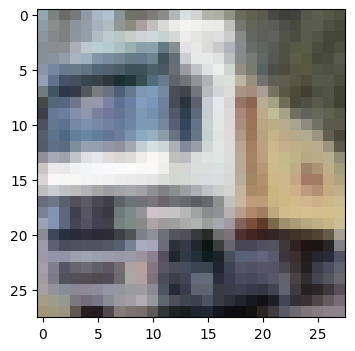

In [26]:
# 資料集繪圖
plt.figure(figsize=(4,4))
plt.imshow(img_tensor_to_np(train_data[1][0]))

# train

In [9]:
generator = DcganGenerator().to(device)
discriminator = DcganDiscriminator().to(device)

In [10]:
LR = 1e-4
BETA = (0.5,0.999)

In [11]:
criterion = nn.BCEWithLogitsLoss()
optim_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=BETA)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=BETA)

In [12]:
epoches = 10

In [ ]:
generator.train()
discriminator.train()
for e in range(epoches):
    running_loss_G = 0.0
    running_loss_D = 0.0

    for img, _ in tqdm(train_loader):
        img = img.to(device)

        valid = torch.ones(BATCH_SIZE, 1).to(device)
        fake = torch.zeros(BATCH_SIZE, 1).to(device)

        noise = generate_standard_normal(BATCH_SIZE, 128).to(device)

        # learn to fool
        optim_G.zero_grad()
        gen_img = generator(noise)
        g_loss = criterion(discriminator(gen_img), valid)
        g_loss.backward()
        optim_G.step()
        running_loss_G += g_loss.item()

        # learn to discriminate
        optim_D.zero_grad()
        real_loss = criterion(discriminator(img), valid)
        fake_loss = criterion(discriminator(gen_img.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optim_D.step()
        running_loss_D += d_loss.item()

    print(
        f"epoch {e+1}: D:{running_loss_D/len(train_data)} G:{running_loss_G/len(train_data)}"
    )

# evaluation

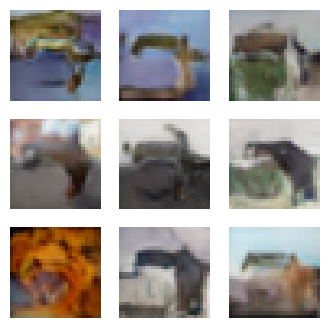

In [19]:
# 合成圖片

generator.eval()
with torch.no_grad():
    noise = generate_gaussian_noise(9, 128)
    gen_img = generator(noise)
    
    plot_grids(
        img_tensor_to_np(gen_img).clip(0, 1),
        num_row=3,
        num_col=3,
        figsize=(4,4),
    )

In [23]:
model_path = artifact_path / 'dcgan.pth'

In [25]:
torch.save(generator.state_dict(), model_path.as_posix())